# Problem 2: System Power Prediction

## Overview
- **Question 1 [20p]**: SVM classifier for big cluster state (active/idle)
- **Question 2 [5p]**: Linear regression to predict big cluster power
- **Question 3 [15p]**: Feature engineering with Vdd²f and feature importance analysis

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, mean_squared_error, r2_score,
    ConfusionMatrixDisplay
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [49]:
# Load datasets
train_data = pd.read_csv('training_dataset.csv')
test_blackscholes = pd.read_csv('testing_blackscholes.csv')
test_bodytrack = pd.read_csv('testing_bodytrack.csv')

print("Training data shape:", train_data.shape)
print("Blackscholes test shape:", test_blackscholes.shape)
print("Bodytrack test shape:", test_bodytrack.shape)
print("\nColumns:", train_data.columns.tolist())
print("\nFirst few rows of training data:")
print(train_data.head())

Training data shape: (5415, 15)
Blackscholes test shape: (1653, 15)
Bodytrack test shape: (1454, 15)

Columns: ['total_watts', 'w_big', 'w_little', 'w_gpu', 'w_mem', 'usage_c4', 'usage_c5', 'usage_c6', 'usage_c7', 'temp4', 'temp5', 'temp6', 'temp7', 'temp_gpu', 'freq_big_cluster']

First few rows of training data:
   total_watts     w_big  w_little     w_gpu     w_mem  usage_c4  usage_c5  \
0        3.065  0.474810  0.033012  0.096321  0.048800       0.0       0.0   
1        2.706  0.235620  0.032095  0.096515  0.032940       0.0       0.0   
2        2.706  0.235620  0.034846  0.096515  0.032940       0.0       0.0   
3        2.637  0.234685  0.034846  0.096321  0.037758       0.0       0.0   
4        2.637  0.233750  0.033929  0.096321  0.032886       0.0       0.0   

   usage_c6  usage_c7  temp4  temp5  temp6  temp7  temp_gpu  freq_big_cluster  
0       0.0       0.0     49     53     52     48        47        1000000000  
1       0.0       0.0     48     52     52     48      

---
## Question 1: SVM Classification [20p]


In [ ]:
# Prepare data for Question 1 (SVM Classification)
# Create binary labels: active (1) if w_big > 1W, idle (0) if w_big < 1W


def prepare_classification_data(df):
    """Prepare features and labels for SVM classification"""
    # Create binary labels
    y = (df['w_big'] > 1.0).astype(int)
    
    # Features: all columns except w_big AND other power features
    feature_cols = [col for col in df.columns if col not in ['w_big']]
    X = df[feature_cols]
    
    return X, y, feature_cols

# Prepare training data
X_train, y_train, feature_cols = prepare_classification_data(train_data)

# Prepare test data
X_test_blackscholes, y_test_blackscholes, _ = prepare_classification_data(test_blackscholes)
X_test_bodytrack, y_test_bodytrack, _ = prepare_classification_data(test_bodytrack)

print(f"Training samples: {len(X_train)}")
print(f"Active samples in training: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"Idle samples in training: {(1-y_train).sum()} ({(1-y_train.mean())*100:.1f}%)")
print(f"\nBlackscholes - Active: {y_test_blackscholes.sum()} ({y_test_blackscholes.mean()*100:.1f}%)")
print(f"Blackscholes - Idle: {(1-y_test_blackscholes).sum()} ({(1-y_test_blackscholes.mean())*100:.1f}%)")
print(f"\nBodytrack - Active: {y_test_bodytrack.sum()} ({y_test_bodytrack.mean()*100:.1f}%)")
print(f"Bodytrack - Idle: {(1-y_test_bodytrack).sum()} ({(1-y_test_bodytrack.mean())*100:.1f}%)")
print(f"\nFeatures used ({len(feature_cols)}): {feature_cols}")

Training samples: 5415
Active samples in training: 1802 (33.3%)
Idle samples in training: 3613 (66.7%)

Blackscholes - Active: 1098 (66.4%)
Blackscholes - Idle: 555 (33.6%)

Bodytrack - Active: 908 (62.4%)
Bodytrack - Idle: 546 (37.6%)

Features used (14): ['total_watts', 'w_little', 'w_gpu', 'w_mem', 'usage_c4', 'usage_c5', 'usage_c6', 'usage_c7', 'temp4', 'temp5', 'temp6', 'temp7', 'temp_gpu', 'freq_big_cluster']


In [66]:
# Scale features for SVM (IMPORTANT: SVM is sensitive to feature scales!)
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_blackscholes_scaled = scaler.transform(X_test_blackscholes)
X_test_bodytrack_scaled = scaler.transform(X_test_bodytrack)

print(f"All features now have mean ≈ 0 and std ≈ 1")

# Train SVM classifier with scaled features
print("\nTraining SVM classifier...")
svm_model = SVC(C=1, kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train)
print("SVM training complete!")

# Make predictions
y_pred_blackscholes = svm_model.predict(X_test_blackscholes_scaled)
y_pred_bodytrack = svm_model.predict(X_test_bodytrack_scaled)

# Check prediction distribution
print(f"\nPredictions on Blackscholes - Active: {y_pred_blackscholes.sum()}, Idle: {len(y_pred_blackscholes) - y_pred_blackscholes.sum()}")
print(f"Predictions on Bodytrack - Active: {y_pred_bodytrack.sum()}, Idle: {len(y_pred_bodytrack) - y_pred_bodytrack.sum()}")

Scaling features...
All features now have mean ≈ 0 and std ≈ 1

Training SVM classifier...
SVM training complete!

Predictions on Blackscholes - Active: 1652, Idle: 1
Predictions on Bodytrack - Active: 1454, Idle: 0


In [67]:
# Calculate performance metrics for training and test sets
def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and display performance metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"\n{dataset_name} Performance:")
    print(f"  Accuracy:       {accuracy*100:.2f}%")
    print(f"  Avg. Precision: {precision:.4f}")
    print(f"  Avg. Recall:    {recall:.4f}")
    print(f"  Avg. F1-Score:  {f1:.4f}")
    
    return {
        'Accuracy [%]': accuracy * 100,
        'Avg. Precision': precision,
        'Avg. Recall': recall,
        'Avg. F1-Score': f1
    }

# Make predictions on training data
y_pred_train = svm_model.predict(X_train_scaled)

# Calculate metrics for training and test sets
metrics_training = calculate_metrics(y_train, y_pred_train, "Training")
metrics_blackscholes = calculate_metrics(y_test_blackscholes, y_pred_blackscholes, "Blackscholes")
metrics_bodytrack = calculate_metrics(y_test_bodytrack, y_pred_bodytrack, "Bodytrack")


Training Performance:
  Accuracy:       99.93%
  Avg. Precision: 0.9989
  Avg. Recall:    0.9994
  Avg. F1-Score:  0.9992

Blackscholes Performance:
  Accuracy:       66.49%
  Avg. Precision: 0.8323
  Avg. Recall:    0.5009
  Avg. F1-Score:  0.4011

Bodytrack Performance:
  Accuracy:       62.45%
  Avg. Precision: 0.3122
  Avg. Recall:    0.5000
  Avg. F1-Score:  0.3844


C:\Users\rovez\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [68]:
# Create Table 2
table2_data = pd.DataFrame([
    {'Benchmark': 'blackscholes', **metrics_blackscholes},
    {'Benchmark': 'bodytrack', **metrics_bodytrack}
])
table2_data = table2_data.set_index('Benchmark')

print("\n" + "="*80)
print("TABLE 2: SVM CLASSIFICATION PERFORMANCE")
print("="*80)
print(table2_data.to_string(float_format=lambda x: f'{x:.2f}' if x > 10 else f'{x:.4f}'))
print("="*80)

# Save to CSV
table2_data.to_csv('q1_table2_metrics.csv')
print("\nTable saved to: q1_table2_metrics.csv")


TABLE 2: SVM CLASSIFICATION PERFORMANCE
              Accuracy [%]  Avg. Precision  Avg. Recall  Avg. F1-Score
Benchmark                                                             
blackscholes         66.49          0.8323       0.5009         0.4011
bodytrack            62.45          0.3122       0.5000         0.3844

Table saved to: q1_table2_metrics.csv


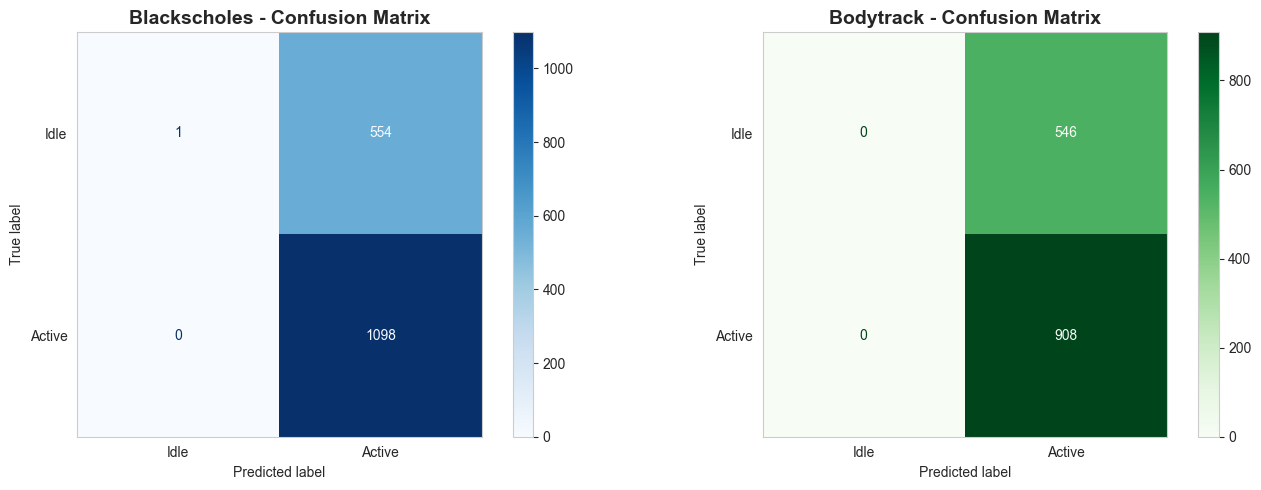

Confusion matrices saved as: q1_confusion_matrices.png


In [69]:
# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Blackscholes confusion matrix
cm_blackscholes = confusion_matrix(y_test_blackscholes, y_pred_blackscholes)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_blackscholes, 
                                display_labels=['Idle', 'Active'])
disp1.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Blackscholes - Confusion Matrix', fontsize=14, fontweight='bold')
ax1.grid(False)

# Bodytrack confusion matrix
cm_bodytrack = confusion_matrix(y_test_bodytrack, y_pred_bodytrack)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_bodytrack, 
                                display_labels=['Idle', 'Active'])
disp2.plot(ax=ax2, cmap='Greens', values_format='d')
ax2.set_title('Bodytrack - Confusion Matrix', fontsize=14, fontweight='bold')
ax2.grid(False)

plt.tight_layout()
plt.savefig('q1_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices saved as: q1_confusion_matrices.png")

### Question 1: Performance Analysis

**Explanation**: The performance is terrible. The model just ends up predicting everything as accurate and does nothing else on the testing set even though it is accurate on the training set and is able to differentiate. Features were normalized but still the performance is terrible.

---
## Question 2: Linear Regression for Power Prediction [5p]

In [71]:
# Prepare data for Question 2 (Linear Regression)
# Exclude all power features as inputs

POWER_FEATURES = ['total_watts', 'w_little', 'w_gpu', 'w_mem']

def prepare_regression_data(df):
    """Prepare features and target for power regression"""
    # Target: w_big
    y = df['w_big']
    
    # Features: all columns except w_big and other power features
    feature_cols = [col for col in df.columns if col not in ['w_big'] + POWER_FEATURES]
    X = df[feature_cols]
    
    return X, y, feature_cols

# Prepare data
X_train_reg, y_train_reg, reg_feature_cols = prepare_regression_data(train_data)
X_test_bs_reg, y_test_bs_reg, _ = prepare_regression_data(test_blackscholes)
X_test_bt_reg, y_test_bt_reg, _ = prepare_regression_data(test_bodytrack)

print(f"Features used for regression ({len(reg_feature_cols)}): {reg_feature_cols}")
print(f"\nTraining samples: {len(X_train_reg)}")
print(f"w_big range in training: [{y_train_reg.min():.3f}, {y_train_reg.max():.3f}] W")

# Scale features for regression
print("\nScaling features for regression...")
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_bs_reg_scaled = scaler_reg.transform(X_test_bs_reg)
X_test_bt_reg_scaled = scaler_reg.transform(X_test_bt_reg)
print("All features normalized (mean ≈ 0, std ≈ 1)")

Features used for regression (10): ['usage_c4', 'usage_c5', 'usage_c6', 'usage_c7', 'temp4', 'temp5', 'temp6', 'temp7', 'temp_gpu', 'freq_big_cluster']

Training samples: 5415
w_big range in training: [0.232, 3.503] W

Scaling features for regression...
All features normalized (mean ≈ 0, std ≈ 1)


In [72]:
# Train Linear Regression model
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)
print("Linear Regression training complete!")

# Make predictions
y_pred_train = lr_model.predict(X_train_reg_scaled)
y_pred_bs = lr_model.predict(X_test_bs_reg_scaled)
y_pred_bt = lr_model.predict(X_test_bt_reg_scaled)

# Calculate metrics
r2_train = r2_score(y_train_reg, y_pred_train)
mse_train = mean_squared_error(y_train_reg, y_pred_train)

r2_bs = r2_score(y_test_bs_reg, y_pred_bs)
mse_bs = mean_squared_error(y_test_bs_reg, y_pred_bs)

r2_bt = r2_score(y_test_bt_reg, y_pred_bt)
mse_bt = mean_squared_error(y_test_bt_reg, y_pred_bt)

print(f"\nTraining Set:")
print(f"  R²:  {r2_train:.4f}")
print(f"  MSE: {mse_train:.4f}")
print(f"\nBlackscholes Test Set:")
print(f"  R²:  {r2_bs:.4f}")
print(f"  MSE: {mse_bs:.4f}")
print(f"\nBodytrack Test Set:")
print(f"  R²:  {r2_bt:.4f}")
print(f"  MSE: {mse_bt:.4f}")

if mse_bs < 0.15 and mse_bt < 0.15:
    print(f"\n✓ SUCCESS: Both test MSE values are less than 0.15!")
else:
    print(f"\n✗ Target not met: MSE should be < 0.15")

Training Linear Regression model...
Linear Regression training complete!

Training Set:
  R²:  0.9870
  MSE: 0.0102

Blackscholes Test Set:
  R²:  0.9566
  MSE: 0.0594

Bodytrack Test Set:
  R²:  0.9224
  MSE: 0.1216

✓ SUCCESS: Both test MSE values are less than 0.15!


In [73]:
# Create Table 3
table3_data = pd.DataFrame({
    'Dataset': ['R²', 'MSE'],
    'training': [r2_train, mse_train],
    'blackscholes': [r2_bs, mse_bs],
    'bodytrack': [r2_bt, mse_bt]
})
table3_data = table3_data.set_index('Dataset')

print("\n" + "="*60)
print("TABLE 3: LINEAR REGRESSION PERFORMANCE")
print("="*60)
print(table3_data.to_string(float_format=lambda x: f'{x:.4f}'))
print("="*60)

# Save to CSV
table3_data.to_csv('q2_table3_metrics.csv')
print("\nTable saved to: q2_table3_metrics.csv")


TABLE 3: LINEAR REGRESSION PERFORMANCE
         training  blackscholes  bodytrack
Dataset                                   
R²         0.9870        0.9566     0.9224
MSE        0.0102        0.0594     0.1216

Table saved to: q2_table3_metrics.csv


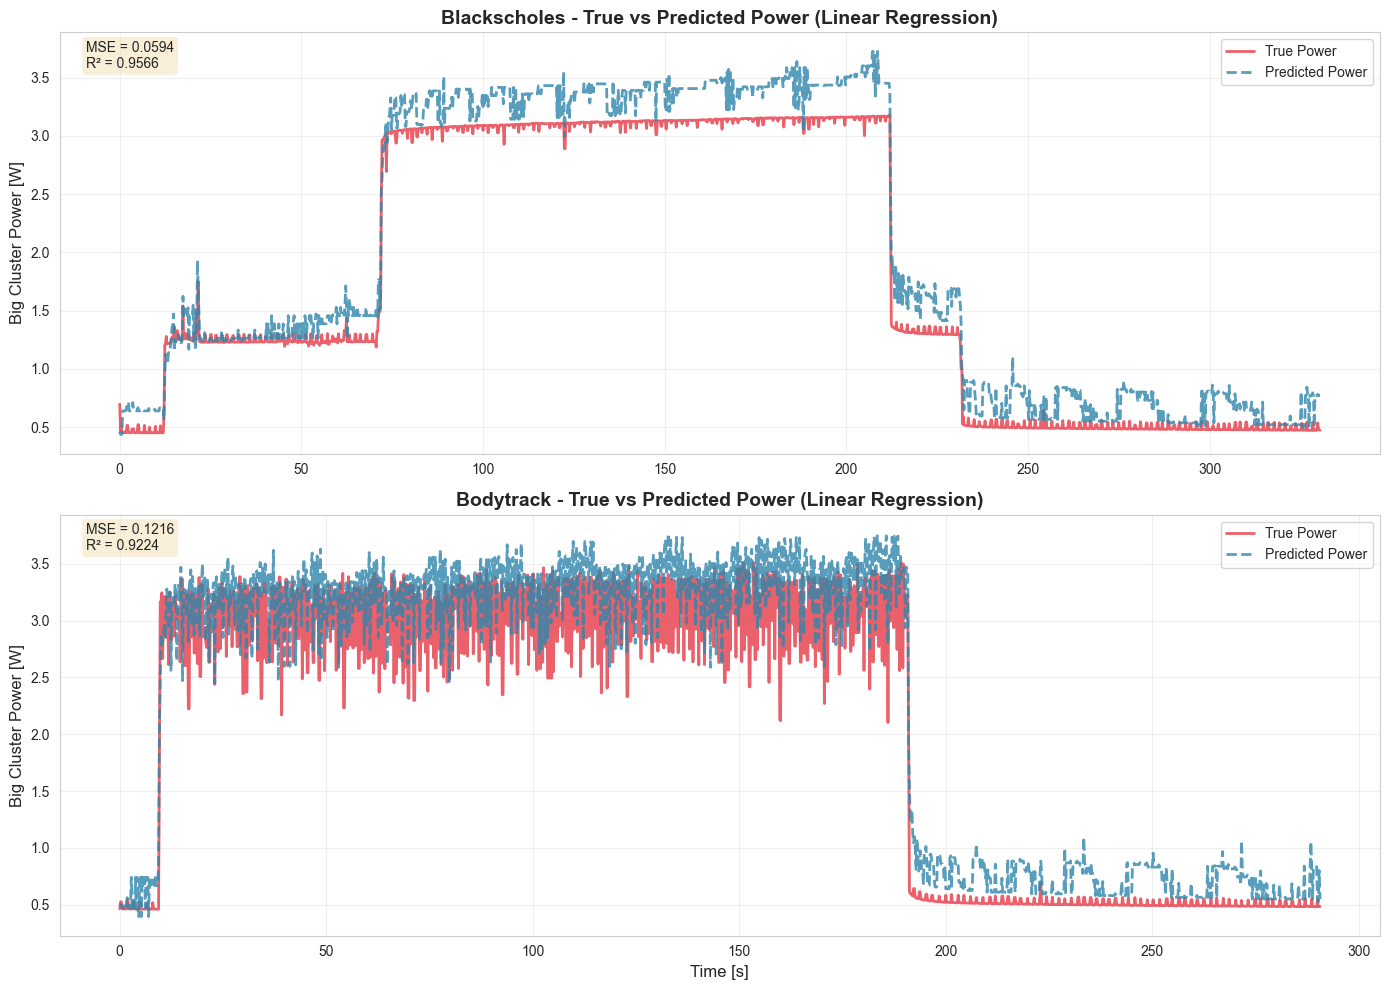

Plots saved as: q2_power_prediction.png


In [ ]:
# Plot true vs predicted power for Blackscholes
# Add time column if not present
time_bs = np.arange(len(y_test_bs_reg)) * 0.2  # 0.2s sampling interval
time_bt = np.arange(len(y_test_bt_reg)) * 0.2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Blackscholes
ax1.plot(time_bs, y_test_bs_reg.values, linewidth=2, color='#E63946', 
         label='True Power', alpha=0.8)
ax1.plot(time_bs, y_pred_bs, linewidth=2, color='#2E86AB', 
         label='Predicted Power', linestyle='--', alpha=0.8)
ax1.set_ylabel('Big Cluster Power [W]', fontsize=12)
ax1.set_title('Blackscholes - True vs Predicted Power (Linear Regression)', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.text(0.02, 0.98, f'MSE = {mse_bs:.4f}\nR² = {r2_bs:.4f}', 
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Bodytrack
ax2.plot(time_bt, y_test_bt_reg.values, linewidth=2, color='#E63946', 
         label='True Power', alpha=0.8)
ax2.plot(time_bt, y_pred_bt, linewidth=2, color='#2E86AB', 
         label='Predicted Power', linestyle='--', alpha=0.8)
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Big Cluster Power [W]', fontsize=12)
ax2.set_title('Bodytrack - True vs Predicted Power (Linear Regression)', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.text(0.02, 0.98, f'MSE = {mse_bt:.4f}\nR² = {r2_bt:.4f}', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('q2_power_prediction.png', dpi=300, bbox_inches='tight')
plt.show()
print("Plots saved as: q2_power_prediction.png")

---
## Question 3: Feature Engineering with Vdd²f [15p]


In [75]:
# Define Vdd-frequency mapping from Table 4
VDD_FREQ_MAP = {
    900000000: 0.975,    # 0.9 GHz
    1000000000: 1.0,     # 1.0 GHz
    1500000000: 1.1375,  # 1.5 GHz
    2000000000: 1.362    # 2.0 GHz
}

def add_vdd_squared_f_feature(df):
    """Add Vdd²f feature to dataframe based on freq_big_cluster"""
    df = df.copy()
    
    # Map frequency to Vdd
    df['vdd'] = df['freq_big_cluster'].map(VDD_FREQ_MAP)
    
    # Calculate Vdd²f (frequency in GHz)
    df['vdd2_f'] = (df['vdd'] ** 2) * (df['freq_big_cluster'] / 1e9)
    
    return df

# Add feature to all datasets
train_data_q3 = add_vdd_squared_f_feature(train_data)
test_bs_q3 = add_vdd_squared_f_feature(test_blackscholes)
test_bt_q3 = add_vdd_squared_f_feature(test_bodytrack)

print("Vdd²f feature added to all datasets!")
print(f"\nNew columns: {[c for c in train_data_q3.columns if c not in train_data.columns]}")
print(f"\nSample values:")
print(train_data_q3[['freq_big_cluster', 'vdd', 'vdd2_f']].head(10))

Vdd²f feature added to all datasets!

New columns: ['vdd', 'vdd2_f']

Sample values:
   freq_big_cluster  vdd  vdd2_f
0        1000000000  1.0     1.0
1        1000000000  1.0     1.0
2        1000000000  1.0     1.0
3        1000000000  1.0     1.0
4        1000000000  1.0     1.0
5        1000000000  1.0     1.0
6        1000000000  1.0     1.0
7        1000000000  1.0     1.0
8        1000000000  1.0     1.0
9        1000000000  1.0     1.0


In [76]:
# Prepare data with new feature (exclude power features)
def prepare_regression_data_q3(df):
    """Prepare features including vdd2_f, excluding power features"""
    y = df['w_big']
    
    # Include vdd2_f but exclude power features and intermediate vdd column
    feature_cols = [col for col in df.columns 
                   if col not in ['w_big', 'vdd'] + POWER_FEATURES]
    X = df[feature_cols]
    
    return X, y, feature_cols

X_train_q3, y_train_q3, q3_feature_cols = prepare_regression_data_q3(train_data_q3)
X_test_bs_q3, y_test_bs_q3, _ = prepare_regression_data_q3(test_bs_q3)
X_test_bt_q3, y_test_bt_q3, _ = prepare_regression_data_q3(test_bt_q3)

print(f"Features used ({len(q3_feature_cols)}):")
for i, col in enumerate(q3_feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Scale features for Q3 regression
print("\nScaling features...")
scaler_q3 = StandardScaler()
X_train_q3_scaled = scaler_q3.fit_transform(X_train_q3)
X_test_bs_q3_scaled = scaler_q3.transform(X_test_bs_q3)
X_test_bt_q3_scaled = scaler_q3.transform(X_test_bt_q3)
print("All features normalized (mean ≈ 0, std ≈ 1)")

Features used (11):
   1. usage_c4
   2. usage_c5
   3. usage_c6
   4. usage_c7
   5. temp4
   6. temp5
   7. temp6
   8. temp7
   9. temp_gpu
  10. freq_big_cluster
  11. vdd2_f

Scaling features...
All features normalized (mean ≈ 0, std ≈ 1)


In [77]:
# Train new Linear Regression model with vdd2_f feature
print("\nTraining Linear Regression with Vdd²f feature...")
lr_model_q3 = LinearRegression()
lr_model_q3.fit(X_train_q3_scaled, y_train_q3)
print("Training complete!")

# Get feature importances (coefficients)
feature_importance = pd.DataFrame({
    'Feature': q3_feature_cols,
    'Coefficient': lr_model_q3.coef_
})
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

print("\nFeature Importances (Coefficients):")
print(feature_importance.to_string(index=False))


Training Linear Regression with Vdd²f feature...
Training complete!

Feature Importances (Coefficients):
         Feature  Coefficient
          vdd2_f     1.514170
           temp4     1.001162
           temp5     0.681568
           temp7     0.572544
           temp6     0.213254
        usage_c7     0.029745
        usage_c4     0.023478
        usage_c5     0.015718
        usage_c6    -0.000972
freq_big_cluster    -1.457372
        temp_gpu    -1.656022


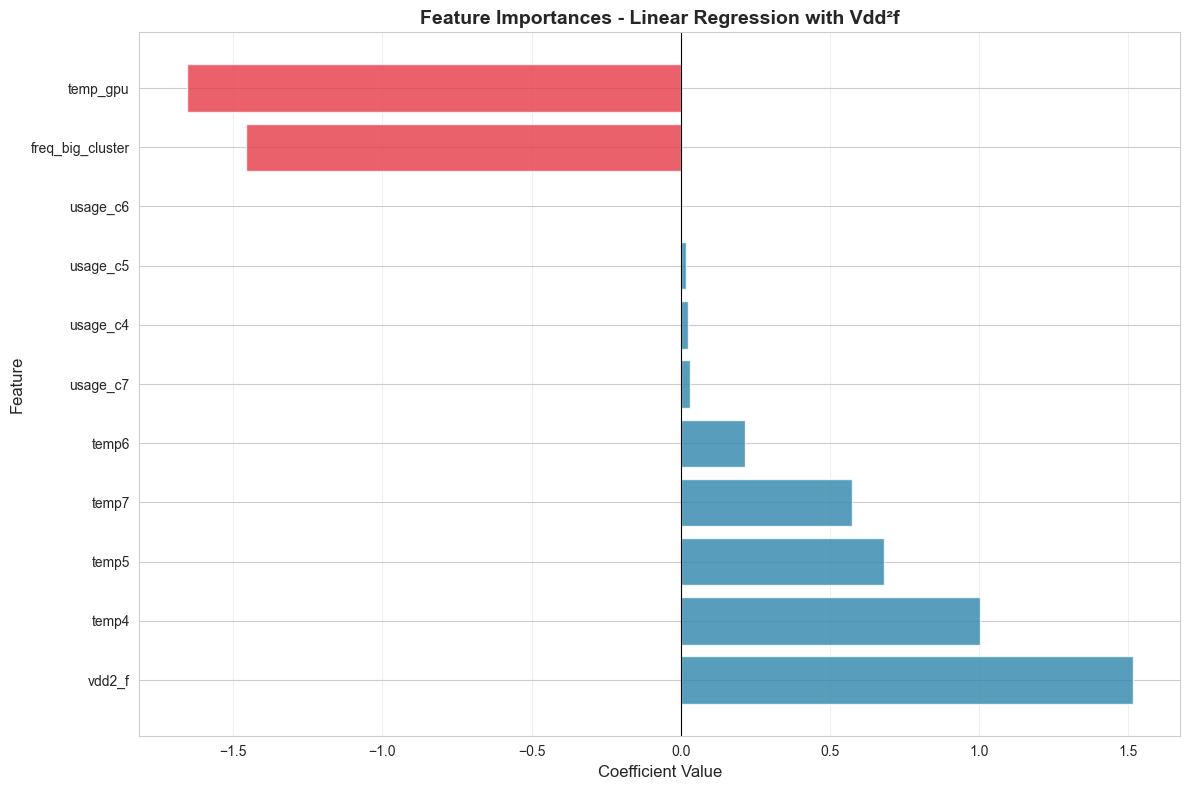

Feature importance plot saved as: q3_feature_importance.png


In [78]:
# Plot feature importances
plt.figure(figsize=(12, 8))
colors = ['#2E86AB' if coef > 0 else '#E63946' for coef in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.8)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importances - Linear Regression with Vdd²f', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('q3_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Feature importance plot saved as: q3_feature_importance.png")

In [79]:
# Identify top 3 positive features
top3_positive = feature_importance[feature_importance['Coefficient'] > 0].head(3)

print("\n" + "="*70)
print("TOP 3 POSITIVE FEATURES")
print("="*70)
for i, (idx, row) in enumerate(top3_positive.iterrows(), 1):
    print(f"{i}. {row['Feature']:20s} : {row['Coefficient']:10.6f}")
print("="*70)


TOP 3 POSITIVE FEATURES
1. vdd2_f               :   1.514170
2. temp4                :   1.001162
3. temp5                :   0.681568


### Question 3: Analysis and Observations

**Top 3 Positive Features Contributing to Big Cluster Power:**

1. **vdd2_f (Vdd²f) [1.514170]**: This feature based on the dynamic power formula P ∝ V²f has the strongest positive correlation with power consumption, confirming the theoretical relationship between voltage, frequency, and dynamic power.

2. **temp4 [1.001162]**: Temperature of Core 4. Most likely the core most frequently assigned by the OS to take on tasks. Assuming that is the case, more tasks lead to more power consumption which generates more heat.

3. **temp5 [0.681568]**: Temperature of Core 5. Most likely the core second most frequently assigned by the OS to take on tasks. Although less by a decent margin. 


The feature importance might be different depending on how parralelizable the task is that's running.

